## Importation des fichiers utiles

In [85]:
import urllib.request
import json
import pandas as pd
import numpy as np
from PIL import Image, ExifTags
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.linear_model import Perceptron
import random
import matplotlib.pyplot as plt

<br>

## Demande de Json
Nous Faisons une Requète WikiData pour demander un Json contenant le lien menant à des libres d'une certaine catégorie. Nous avons essayé plusieurs types d'images différentes :

mythical creature = Q2239243<br>
photograph = Q125191<br>
flower = Q506<br>
fruit = Q1364<br>
Chien = Q144<br>
lac  = Q23397<br>


SELECT ?image ?im WHERE {
  ?image wdt:P31 wd:Q506.
  ?image wdt:P18 ?im
  }
LIMIT 200

In [45]:
lstSources = {"Fruit":1364,"Dog":144,"Lake":23397}
limitPerSources = 5
sources = {}
tagTemp = []
for key,value in lstSources.items():    #Get all images to download
    url ="https://query.wikidata.org/sparql?query=SELECT%20%3Fimage%20%3Fim%20WHERE%20%7B%0A%20%20%3Fimage%20wdt%3AP31%20wd%3AQ"+str(value)+".%0A%20%20%3Fimage%20wdt%3AP18%20%3Fim%0A%20%20%7D%0ALIMIT%20"+str(limitPerSources)+"&format=json"
    response = urllib.request.urlopen(url)
    myJson = json.loads(response.read().decode("utf-8"))
    
    for image in myJson["results"]["bindings"]:  #Add the tag to the image
        image['tag'] = key
        
    if sources == {}:   #Make one big json containing all images
        sources = myJson
    else:
        sources["results"]["bindings"] = sources["results"]["bindings"]+myJson["results"]["bindings"]

myJsonNormalized = pd.json_normalize(sources)

<br>

## Télechargement des images ##
A partir du Json contenant les liens menant aux images, nous lancons des requètes URLLIB pour télecharger ces images.

In [46]:
#telechargement des images

responseJson = myJsonNormalized["results.bindings"]
index=0
lstTag=[]
for i in range(len(responseJson[0])):   
    imageLink = responseJson[0][i]["im"]["value"]
    lstTag.append(responseJson[0][i]["tag"])
    print(index)
    
    im = "./images/image"+str(index)+".jpg"
    urllib.request.urlretrieve(imageLink, im)
    index +=1

    try:
        imgfile = Image.open(im).convert("RGB")
    except:
        index-=1
        del lstTag[-1]
        print("pas fonctionne")
    
NOMBRE_IMAGE=index

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


<br>

## Récupération des métadonnées
L'obhectif de cette partie est de récupérer les informations des images, nous récupérons les images suivantes :<br>
1. Récupération Exif utiles
2. Récupération couleurs dominantes (K-means)
3. Récupération taille des images
4. Détermination portrait ou paysage

Apres cela, nous avons creer un Json **metaDataJson.json** contenant toutes les informationns precedentes

In [47]:
# Récupération des métadonnées

metaData ={}
for i in range(NOMBRE_IMAGE):
    im = "./images/image"+str(i)+".jpg"
    try:
        imgfile = Image.open(im).convert("RGB")

        #Recupération Exif utiles
        exif = {}
        exifCritere= ("Model","Make","ImageDescription","ExposureTime","GPSInfo","ISO","DateTimeOriginal")
        for k,v in  imgfile.getexif().items() :
            if k in ExifTags.TAGS :
                if ExifTags.TAGS[k] in exifCritere:
                    exif = {ExifTags.TAGS[k]:v}

        # Recupération couleurs dominantes (K-means)
        numarray = np.array(imgfile.getdata(), np.uint8)
        clusters  = MiniBatchKMeans(n_clusters=3, n_init=2) 
        clusters.fit(numarray)
        L = clusters.cluster_centers_.astype(int).tolist()
        if L[0][0]>L[0][1] and L[0][0]>L[0][2]:
            domColor = "Red"
        elif L[0][1]>L[0][0] and L[0][1]>L[0][2]:
            domColor = "Green"
        elif L[0][2]>L[0][0] and L[0][2]>L[0][1]:
            domColor = "Blue"
        elif L[0][0]==L[0][1]==L[0][2]:
            domColor = "White"
        else:
            domColor = "None"

        # Recupération taille des images
        width = imgfile.width
        height = imgfile.height
        mode = imgfile.mode

        # Détermination portrait ou paysage
        if abs(1-width/height)<0.1 :
            orientation='carre' 
        elif width>height:
            orientation='paysage'
        else: 
            orientation="portrait"

        # Get image size (big, small, ...)
        pixelCount = width * height

        if pixelCount >= 1920*1080:
            size = "Grande"
        elif pixelCount >= 1280*720:
            size = "Moyenne"
        elif pixelCount >= 720*480:
            size = "Petite"
        elif pixelCount < 720*480:
            size = "Vignette"
        else:
            size = "WTF"

        metaData["image"+str(i)] = { "width" : width, "height": height, "exif": exif, "mode":mode, "tags":[lstTag[i]], "couleurs":L, "orientation":orientation, "size":size, "dom":domColor}
    except Exception:
        print("l'image "+str(i) +" ne peut pas etre ouverte")
metaData

metaDatajson = json.dumps(metaData)
f = open("metaDataJson.json", "w")
f.write(metaDatajson)
f.close()



## Analyse

Consiste en 2 parties, l'analyse couleur, pour savoir si l'image proposée à des couleurs proche des images aimées par l'utilisateur. Et l'analyse globale qui utilise un arbre de décision et les paramètres de metadataJson pour décider si l'image peut etre proposée ou non à l'utilisateur.

In [48]:
def flatten(l):
    return [item for sublist in l for item in sublist]


def analyseCouleur(numUser,numImage): 
    couleurs=[]
    

    
    jsonUserDF=pd.read_json("jsonUser.json")
    jsonMetaDF=pd.read_json("metaDataJson.json")
    userId="user"+str(numUser)
    for image in jsonUserDF[userId]["images"]:
        couleurs.append(flatten(jsonMetaDF[image]["couleurs"]))
    

    numarray=np.array(couleurs)
    like=np.array(jsonUserDF[userId]["result"])
  
    # modele des couleurs
    percep = Perceptron(max_iter=1000)
    percep.fit(numarray, like)

    # prediction
    nomImage=str(numImage)
    x_predict = np.array([flatten(jsonMetaDF[nomImage]["couleurs"])])
    y_predict = percep.predict(x_predict)

    return y_predict[0]

analyseCouleur(1,"image1")

1

In [49]:
from sklearn.preprocessing import OrdinalEncoder
def analyseGlobal(userIndex,nomImage):

    # Get image data
    jsonMetaDF = pd.read_json("metaDataJson.json")

    # Get user like
    userDF = pd.read_json("jsonUser.json")
    userImages = userDF.loc["images"][userIndex]
    userLike = userDF.loc["result"][userIndex]

    data = []
    for item in userImages:
        imageDesc = []
        #imageDesc.append(jsonMetaDF.loc["couleurs"][item])
        imageDesc.append(jsonMetaDF.loc["dom"][item])
        imageDesc.append(jsonMetaDF.loc["tags"][item][0])
        imageDesc.append(jsonMetaDF.loc["size"][item])
        imageDesc.append(jsonMetaDF.loc["orientation"][item])
        imageDesc.append(analyseCouleur(userIndex,item))
        data.append(imageDesc)


    result = [None]*len(userImages)
    for item in jsonMetaDF:
        if item in userImages:
            ind = userImages.index(item)
            if userLike[ind] == 1:
                result[ind]="Favorite"
            else :
                result[ind]="NotFavorite"

    # creating dataframes
    dataframe = pd.DataFrame(data, columns=["dom", "tags", "size", "orientation","likedColor"])
    resultframe = pd.DataFrame(result, columns=["favorite"])

    #print(dataframe["dom"])

    le1 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    dataframe["dom"] = le1.fit_transform(dataframe["dom"].values.reshape(-1,1))

    le2 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    dataframe["tags"] = le2.fit_transform(dataframe["tags"].values.reshape(-1,1))

    le3 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    dataframe["size"] = le3.fit_transform(dataframe["size"].values.reshape(-1,1))

    le4 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    dataframe["orientation"] = le4.fit_transform(dataframe["orientation"].values.reshape(-1,1))

    le5 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    dataframe["likedColor"] = le5.fit_transform(dataframe["likedColor"].values.reshape(-1,1))

    le6 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    resultframe["favorite"] = le6.fit_transform(resultframe["favorite"].values.reshape(-1,1))
    
    # # generating numerical labels
    # le1 = LabelEncoder()
    # dataframe["dom"] = le1.fit_transform(dataframe["dom"])

    # le2 = LabelEncoder()
    # dataframe["tags"] = le2.fit_transform(dataframe["tags"])

    # le3 = LabelEncoder()
    # dataframe["size"] = le3.fit_transform(dataframe["size"])

    # le4 = LabelEncoder()
    # dataframe["orientation"] = le4.fit_transform(dataframe["orientation"])

    # le5 = LabelEncoder()
    # resultframe["favorite"] = le5.fit_transform(resultframe["favorite"])

    # Use of decision tree classifiers
    dtc = tree.DecisionTreeClassifier()
    dtc = dtc.fit(dataframe.values, resultframe)


    #prediction

    colorP = jsonMetaDF.loc["dom"][nomImage]
    tagsP = jsonMetaDF.loc["tags"][nomImage]
    sizeP = jsonMetaDF.loc["size"][nomImage]
    orientationP = jsonMetaDF.loc["orientation"][nomImage]
    colorLikeP = analyseCouleur(userIndex,nomImage)
    
    prediction = dtc.predict(np.array([
        
            le1.transform(pd.DataFrame([colorP], columns=["couleur"]))[0],
            le2.transform(pd.DataFrame([tagsP], columns=["tag"]))[0],
            le3.transform(pd.DataFrame([sizeP], columns=["size"]))[0],
            le4.transform(pd.DataFrame([orientationP], columns=["orientation"]))[0],
            le5.transform(pd.DataFrame([colorLikeP], columns=["likedColor"]))[0],
        
    ]).reshape(1,-1))
    
    print(dtc.feature_importances_)
    return le6.inverse_transform(prediction.reshape(-1,1)).tolist()[0][0]
    
#TODO Vérifier que likedColor pas toujours le seul critère déterminant
analyseGlobal(1,"image1")


[0.         0.66666667 0.         0.33333333 0.        ]


c:\Users\augus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
c:\Users\augus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
c:\Users\augus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
c:\Users\augus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
c:\Users\augus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


'Favorite'

## Systeme de recommendation

In [54]:
def createUser(nom, prenom, images = None,like = None):
    jsonUser=json.load(open("jsonUser.json"))
    if images == None:
        firstImage = "image" + str(random.randint(0,NOMBRE_IMAGE-1))
        images = [firstImage]
        like = [random.randint(0,1)]
    
    userId="user"+str(len(jsonUser))
    if len(images) == len(like) :
        jsonUser[userId]={"nom" : nom,"prenom" : prenom, "images":images,"result":like,"year":"","size":"","tagFav":"","orientation":"","colorFav":""}
    else :
        print("Entrez des listes d'images et de like de taille égale svp")
    
    
    jsonUserStr = json.dumps(jsonUser, indent=4)
    f = open("jsonUser.json", "w")
    f.write(jsonUserStr)
    f.close()  
createUser("Jean", "Culetamère")


In [51]:
def demandeFavoriteOrNot(nomImage,typeEnjoyer="likeAll"):
    jsonMetaDF = pd.read_json("metaDataJson.json")
   
    if typeEnjoyer =="likeAll":
        return 'Favorite'
    elif typeEnjoyer =="dogEnjoyer":
        print(nomImage)
        #print(jsonMetaDF[nomImage])
        if "Dog" in jsonMetaDF[nomImage]["tags"]:
            return 'Favorite'
        else:
            return 'NotFavorite'
            




def cyclePropositionImage(numUser,typeEnjoyer):
    userId="user"+str(numUser)
    jsonMetaDF = pd.read_json("metaDataJson.json")
    jsonUserDF=pd.read_json("jsonUser.json")
    imageDonee=[]
    imagePasDonnes=[]
    imageAdonne=1
    for image in jsonMetaDF:
        if image not in jsonUserDF[userId]["images"]:
            
            ana=analyseGlobal(numUser,image)
            if ana==('Favorite'):
                imageDonee.append(image)
            else:
                imagePasDonnes.append(image)
    
    if imageDonee!=[]:
        imageAdonne=random.choice(imageDonee)
        print(imageAdonne)
        jsonUserDF[userId]["images"].append(imageAdonne)
    else:
        imageAdonne=random.choice(imagePasDonnes)
        jsonUserDF[userId]["images"].append(imagePasDonnes)
    #print(imageAdonne)
    res = demandeFavoriteOrNot(numUser,imageAdonne,typeEnjoyer)
    
    if res=='Favorite':
        jsonUserDF[userId]["result"].append(1)
    elif res=='NotFavorite':
        jsonUserDF[userId]["result"].append(0)
    else:
        print("Error : demandeFavoriteOrNot does not return expected results") 
    print(jsonUserDF)
    jsonUserDF.to_json("jsonUser.json",orient='columns',indent=4)               

cyclePropositionImage(6,"dogEnjoyer")

def testNcycle(N):
    for i in range(N):
        cyclePropositionImage(1,"dogEnjoyer")
        analyseGlobal(1,3)
        #cyclePropositionImage(2,"likeAll")
        #analyseGlobal(3,9)
#testNcycle(9)





ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

## Brouillon


In [ ]:
 
jsonUser=json.load(open("jsonUser.json"))[numUser]
jsonMeta=json.load(open("metaDatajson.json"))
couleurs=[]
dataArray=[]
for image in jsonMeta:
    if image in jsonUser["data"]["image"]:
    #image correspond maintenant aux informations des images testees
        L=[]
        dataImage=[]
        if jsonMeta[image]["tags"]==[]:
            dataImage.append(None)
        else:
            dataImage.append(jsonMeta[image]["tags"])
        dataImage.append(jsonMeta[image]["orientation"])
        dataImage.append(jsonMeta[image]["width"])

        for couleur in jsonMeta[image]["couleurs"]:
            for valeurRBG in couleur:
                L.append(valeurRBG)
        dataArray.append(dataImage)
        couleurs.append(L)
print(dataArray)
numarray=np.array(couleurs)
like=np.array(jsonUser["data"]["resultat"])
    
#modele des couleurs
percep = Perceptron(max_iter=1000)
percep.fit(numarray, like)
    

#modele arbre de decision generale
dataFrame = pd.DataFrame(dataArray, columns=["tags", "orientation", "mode"])
likeFrame=pd.DataFrame(like,columns=['like'])


le1 = LabelEncoder()
dataFrame['tags'] = le1.fit_transform(dataFrame['tags'])

le2 = LabelEncoder()
dataFrame['orientation'] = le2.fit_transform(dataFrame['orientation'])

le3 = LabelEncoder()
dataFrame['mode'] = le3.fit_transform(dataFrame['mode'])

le4 = LabelEncoder()
likeFrame['like'] = le4.fit_transform(likeFrame['like'])

NameError: name 'numUser' is not defined

## Update user preferences

In [52]:
user = "user0" #Select user

def userPreferences(all = 1, user = None):

     # Get ima
     jsonMetaDF = pd.read_json("metaDataJson.json")

     # Get user like
     userDF = pd.read_json("jsonUser.json")

     userlst = []
     if all == 1:
          for user in userDF:
               userlst.append(user)
     else:
          userlst.append(user)

     for user in userlst:
          userImages = userDF.loc["images"][user]
          userLike = userDF.loc["result"][user]
          likedImages = []
          for item in userImages :
               ind = userImages.index(item)
               if userLike[ind] == 1:
                    likedImages.append(item)

          if len(likedImages) > 0:
               ori = []
               siz = []
               tagF = []
               colorF = []
               for image in likedImages :
                    ori.append(jsonMetaDF.loc["orientation"][image])
                    siz.append(jsonMetaDF.loc["size"][image])
                    tagF.append(jsonMetaDF.loc["tags"][image])
                    colorF.append(jsonMetaDF.loc["dom"][image])

               jsonUser=json.load(open("jsonUser.json"))
               jsonUser[user]["orientation"]=max(ori,key = ori.count)
               jsonUser[user]["size"]=max(siz,key = siz.count)
               jsonUser[user]["tagFav"]=max(tagF,key = tagF.count)
               jsonUser[user]["colorFav"]=max(colorF,key = colorF.count)
               
               jsonUserStr = json.dumps(jsonUser, indent=4)
               f = open("jsonUser.json", "w")
               f.write(jsonUserStr)
               f.close()  

userPreferences() # Updates all user preferences

KeyError: 'image72'

## Show User Preferences

In [ ]:
def printUserPref(user = None):
    if user == None:
        userDF = pd.read_json("jsonUser.json")
    else :
        userDF = pd.read_json("jsonUser.json")
        userDF = userDF[user]
    return userDF["orientation":"colorFav"]

printUserPref() # Show all user preferences

,user0,user1,user2,user3,user4,user5
orientation,paysage,paysage,portrait,paysage,,
size,Grande,Petite,Moyenne,Grande,,
tagFav,[Fruit],[Fruit],[Dog],[Fruit],,
colorFav,Red,Red,White,Red,NaN,NaN


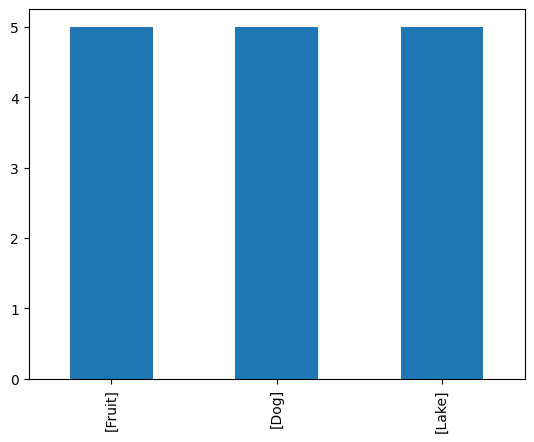

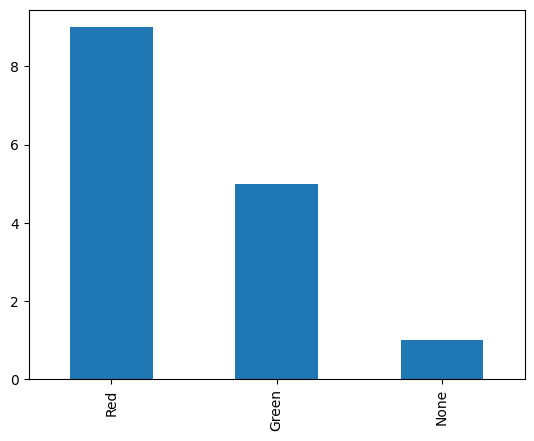

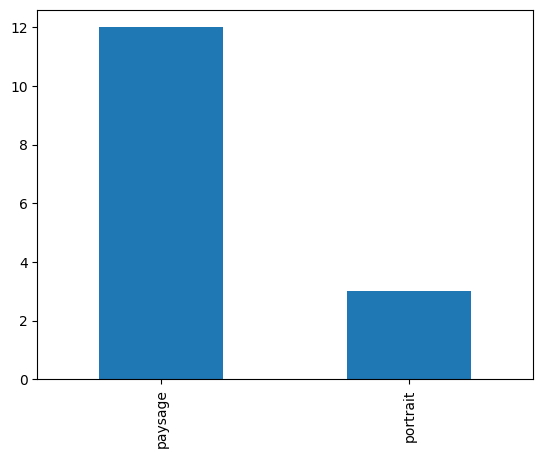

[]

In [103]:
# Plot user liked images' stats : tags, size, ...
def plotPref(plotLst = ["tags","dom","orientation","size"],user = None):
    userDF = pd.read_json("jsonUser.json")
    jsonMetaDF = pd.read_json("metaDataJson.json")

    toPlotCount = []
    if type(plotLst) != list:
        plotLst = [plotLst]
    
    if user == None :
        for stat in plotLst :
            if stat in ["tags","dom","orientation","size"]:     # Stats that can be plotted are in this list
                toPlot = []
                for image in jsonMetaDF :
                    toPlot.append(jsonMetaDF.loc[stat][image])
                    
                toPlotCount.append(pd.Series(toPlot).value_counts())

    if user != None and user in userDF:
        for stat in plotLst :
            if stat in ["tags","dom","orientation","size"]:     # Stats that can be plotted are in this list
                toPlot = []
                for image in userDF[user]["images"] :
                    toPlot.append(jsonMetaDF.loc[stat][image])
                toPlotCount.append(pd.Series(toPlot).value_counts())
        
    for plotCount in toPlotCount:
        fig = plt.figure()
        plotCount.plot.bar()
    plt.show()

plotPref(["tags","dom","orientation"])
